In [1]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from data import *
import tensorflow as tf
import keras.layers
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt

# fix random seed for reproducibility
np.random.seed(7)
tf.set_random_seed(7)

BATCH_SIZE = 64
EPOCHS = 20
LSTM_NODES =256
NUM_SENTENCES = 20000
MAX_SENTENCE_LENGTH = 50
MAX_NUM_WORDS = 20000
EMBEDDING_SIZE = 100

input_sentences = []
output_sentences = []
output_sentences_inputs = []

count = 0
for line in open(r'./fra.txt', encoding="utf-8"):
    count += 1

    if count > NUM_SENTENCES:
        break

    if '\t' not in line:
        continue

    input_sentence, output,_ = line.rstrip().split('\t')

    output_sentence = output + ' <eos>'
    output_sentence_input = '<sos> ' + output

    input_sentences.append(input_sentence)
    output_sentences.append(output_sentence)
    output_sentences_inputs.append(output_sentence_input)

print("num samples input:", len(input_sentences))
print("num samples output:", len(output_sentences))
print("num samples output input:", len(output_sentences_inputs))

Using TensorFlow backend.


num samples input: 20000
num samples output: 20000
num samples output input: 20000


In [2]:
print(input_sentences[:5])
print(output_sentences[:5])


['Go.', 'Hi.', 'Hi.', 'Run!', 'Run!']
['Va ! <eos>', 'Salut ! <eos>', 'Salut. <eos>', 'Cours\u202f! <eos>', 'Courez\u202f! <eos>']


In [3]:
input_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print('Total unique words in the input: %s' % len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Length of longest sentence in input: %g" % max_input_len)

output_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
output_tokenizer.fit_on_texts(output_sentences + output_sentences_inputs)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print('Total unique words in the output: %s' % len(word2idx_outputs))

num_words_output = len(word2idx_outputs) + 1
max_out_len = max(len(sen) for sen in output_integer_seq)
print("Length of longest sentence in the output: %g" % max_out_len)

#x and y
encoder_input_sequences = sequence.pad_sequences(input_integer_seq, maxlen=max_input_len)
decoder_input_sequences = sequence.pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
                                                 
decoder_targets_one_hot = np.zeros((len(input_sentences),max_out_len,num_words_output),dtype='float32')
for i, d in enumerate(output_integer_seq):
    for t, word in enumerate(d):
        decoder_targets_one_hot[i, t, word] = 1
decoder_targets_one_hot.shape

Total unique words in the input: 3514
Length of longest sentence in input: 6
Total unique words in the output: 9532
Length of longest sentence in the output: 13


(20000, 13, 9533)

In [4]:
#input embeddings, could use Glove or Word2vec, I use costum embedding just for convenience, result worse than glove
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
print(num_words)
# embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_input_len)
embedding_layer = Embedding(num_words, EMBEDDING_SIZE, input_length=max_input_len)

3515


Instructions for updating:
Colocations handled automatically by placer.


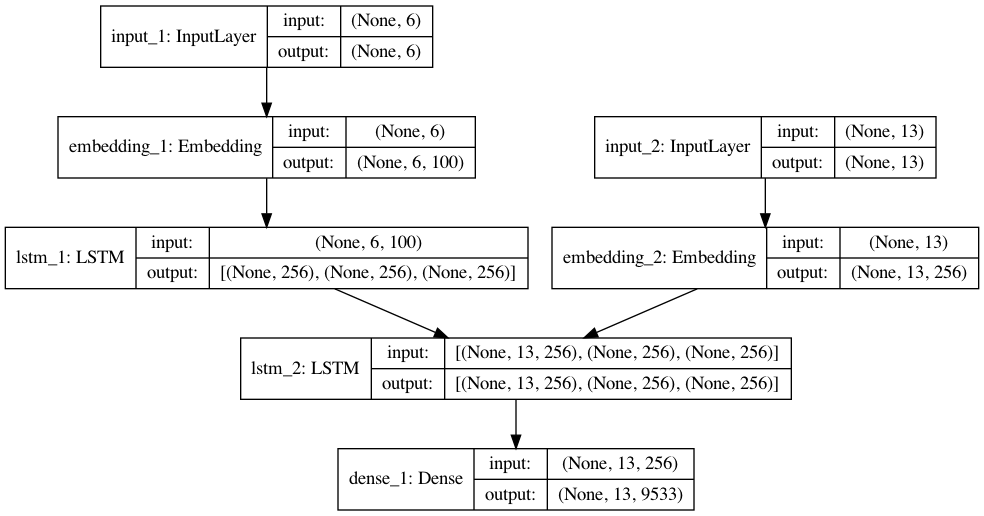

In [5]:
#encoder
encoder_inputs_placeholder = Input(shape=(max_input_len,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = LSTM(LSTM_NODES, return_state=True)

encoder_outputs, h, c = encoder(x)
encoder_states = [h, c]
#decoder
decoder_inputs_placeholder = Input(shape=(max_out_len,))

decoder_embedding = Embedding(num_words_output, LSTM_NODES)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

decoder_lstm = LSTM(LSTM_NODES, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

#dense/softmax
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

#compile
model = Model([encoder_inputs_placeholder,
  decoder_inputs_placeholder], decoder_outputs)
model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
from keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

In [ ]:
r = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets_one_hot,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1,
)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 18000 samples, validate on 2000 samples
Epoch 1/20
18000/18000 [==============================] - 108s 6ms/step - loss: 1.8735 - accuracy: 0.0942 - val_loss: 2.0529 - val_accuracy: 0.1218
Epoch 2/20
18000/18000 [==============================] - 108s 6ms/step - loss: 1.5584 - accuracy: 0.1211 - val_loss: 1.9041 - val_accuracy: 0.1406
Epoch 3/20
18000/18000 [==============================] - 110s 6ms/step - loss: 1.3823 - accuracy: 0.1486 - val_loss: 1.7636 - val_accuracy: 0.1618
Epoch 4/20
18000/18000 [==============================] - 108s 6ms/step - loss: 1.2563 - accuracy: 0.1670 - val_loss: 1.6934 - val_accuracy: 0.1708
Epoch 5/20
18000/18000 [==============================] - 109s 6ms/step - loss: 1.1677 - accuracy: 0.1794 - val_loss: 1.6450 - val_accuracy: 0.1774
Epoch 6/20
18000/18000 [==============================] - 108s 6ms/step - loss: 1.095